# Tool Calling in LangChain and LangGraph

This notebook provides a detailed demonstration of the steps and code required to showcase support for Chat models, including the integration of tools using LangGraph and watsonx.ai models.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Goal 
The purpose of this notebook is to demonstrate how to use Chat models, e.g. `mistralai/mistral-medium-2505` using the tools available in LangChain and LangGraph. LangGraph is an Agent Orchestrator with which you can build graph applications that automatically execute sequences of actions and in which the LLM is the key decision maker that determines the next step. This notebook provides the steps to create a market research agent consisting of various tools such as DuckDuckGo, Wikipedia, and GoogleTrends. 

## Table of Contents 
 
This notebook contains the following parts:

- [Environment Setup](#environment_setup)
- [Foundation Models on watsonx](#fm_setup)
- [LangChain integration](#langchain_integration)
- [Examples](#examples)
- [Summary](#summary)

<a id="environment_setup"></a>
## Environment Setup


### Watsonx.ai Runtime Service
Before you use the sample code in this notebook, ensure an instance of the watsonx.ai Runtime Service is created and associated to the project. The lab guide provides more information on how to associate the watsonx.ai Runtime Service to the watsonx.ai project.

### Install and import the `datasets` and dependencies

In [3]:
!pip install -U "langgraph>0.2,<0.3" | tail -n 1
!pip install -U "langchain_ibm>=0.3,<0.4" | tail -n 1
!pip install ddgs

!pip install langchain wikipedia
!pip install pytrends
!pip install defeatbeta_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.7/356.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 89.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 90.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 46.9 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.8.10
    Uninstalling tabulate-0.8.10:
      Successfully uninstalled tabulate-0.8.10
  Att

In [4]:
# Needed for DuckDuckGo search tool
import ddgs 

from ddgs import DDGS

## Needed for Wikipedia Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper

###
from pytrends.request import TrendReq
from langchain.chat_models import ChatOpenAI # remove this?

## Needed to create tools in LangChain
from langchain.tools import tool

## Needed for Yahoo Finance Tool
from defeatbeta_api.data.ticker import Ticker

______      __           _    ______      _        
|  _  \    / _|         | |   | ___ \    | |       
| | | |___| |_ ___  __ _| |_  | |_/ / ___| |_ __ _ 
| | | / _ \  _/ _ \/ _` | __| | ___ \/ _ \ __/ _` |
| |/ /  __/ ||  __/ (_| | |_  | |_/ /  __/ || (_| |
|___/ \___|_| \___|\__,_|\__| \____/ \___|\__\__,_|
📈:: Data Update Time ::	2025-09-01 ::
📈:: Software Version ::	0.0.13      ::


### Define the watsonx.ai credentials
Use the code cell below to define the watsonx.ai credentials that are required to work with watsonx Foundation Model inferencing.

**Action:** Provide the IBM Cloud user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">Managing user API keys</a>.

In [9]:
import getpass
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    api_key=getpass.getpass("Enter your watsonx.ai api key and hit enter: "),
)

Enter your watsonx.ai api key and hit enter:  ········


### Define the project ID
You need to provide the project ID to give the Foundation Model the context for the call. If you have a default project ID set in Watson Studio, the notebook obtains that project ID. Otherwise, you need to provide the project ID in the code cell below.

In [10]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Enter your project_id and hit enter: ")

<a id="fm_setup"></a>
## Set up a Foundation Model on `watsonx.ai`

In [11]:
model_id = "mistralai/mistral-medium-2505"

<a id="langchain_integration"></a>

## LangChain integration

`ChatWatsonx` is a wrapper around watsonx.ai models that provides chat integration around the models.

### Initialize the `ChatWatsonx` class

In [12]:
from langchain_ibm import ChatWatsonx

chat = ChatWatsonx(
    url=credentials["url"],
    apikey=credentials["apikey"],
    model_id=model_id,
    project_id=project_id,
)

### Define the assistant's tools 

In [13]:
from langchain_core.tools import tool

@tool
def duckduckgo_search(query: str) -> str:
    """Use this tool to search the web using DuckDuckGo. Input should be a search query."""    
    with DDGS() as ddgs:
        results = ddgs.text(query)
        if results:
            return results[0]['body']  # Return the snippet of the first result
        else:
            return "No results found."

@tool
def wikipedia_tool(query: str) -> str:
    """Useful for answering questions about general knowledge or historical topics using Wikipedia."""    
    wiki = WikipediaAPIWrapper()
    func=WikipediaQueryRun(api_wrapper=wiki).run


@tool
def get_google_trends(keyword: str) -> str:
    "Use this tool to get Google search trend data for a specific keyword over the past year."
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], cat=0, timeframe='today 12-m', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()

    if interest_over_time_df.empty:
        return f"No trend data found for '{keyword}'."
    
    trend_summary = interest_over_time_df[keyword].describe()
    return (
        f"Google Trends data for '{keyword}':\n"
        f"- Mean interest: {trend_summary['mean']:.2f}\n"
        f"- Max interest: {trend_summary['max']}\n"
        f"- Min interest: {trend_summary['min']}\n"
        f"- Data points: {len(interest_over_time_df)}"
    )


@tool
def yahoo_finance_data(ticker_symbol: str) -> str:
    "Retrieves historical stock data using defeatbeta-api (no API key required)."
    ticker = Ticker(ticker_symbol)
    df = ticker.price()

    latest = df.iloc[-1]

    return (
        f"{ticker_symbol} on {latest['report_date']}:\n"
        f"Open: {latest['open']}, Close: {latest['close']}, "
        f"High: {latest['high']}, Low: {latest['low']}, Volume: {latest['volume']}"

    )


tools = [duckduckgo_search, wikipedia_tool, yahoo_finance_data, get_google_trends]

### Define the graph.

In [14]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(chat, tools=tools)

### Visualize the graph you just created.

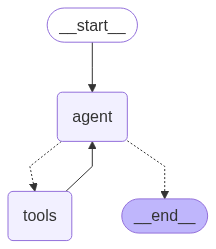

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Add a helpful function to print messages from the model.

In [16]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

<a id="examples"></a>

## Examples

Run the app with an input that needs a tool call. 

<b>Note:</b> Results may differ each time the code is run.

### Example 1 - DuckDuckGo Tool

In [ ]:
inputs = {"messages": [("user", "What is the latest news about AI regulation?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the latest news about AI regulation?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (aOn5WnuI9)
 Call ID: aOn5WnuI9
  Args:
    query: latest news about AI regulation.
================================= Tool Message =================================
Name: duckduckgo_search

Aug 22, 2025 · AI latest regulations 2025: In a bid to curb state-level AI regulations , tech giants like OpenAI, Google, and Meta are lobbying for a federal framework that prioritizes AI use regulation over development. Discover the implications of this pushback on innovation and consumer protection.
================================== Ai Message ==================================

**Highlights on AI latest regulations 2025:**

In the ever-evolving landscape of artificial intelligence (AI) policy, August 2025 brings significant developments that shape the future o

### Example 2 - DuckDuckGo Tool

In [ ]:
inputs = {"messages": [("user", "What are the latest news headlines about IBM?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What are the latest news headlines about IBM?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (f2sJSxiQ2)
 Call ID: f2sJSxiQ2
  Args:
    query: latest news headlines about IBM
================================= Tool Message =================================
Name: duckduckgo_search

By Justina Nixon-Saintil | VP, CSR and Chief Impact Officer NORTHAMPTON, MA / ACCESS Newswire / March 6, 2025 / IBM has been working with ...
================================== Ai Message ==================================

Here are some of the latest news headlines about IBM:

1. **IBM Stock Hits New High on Quantum Computing Breakthrough**
   - Source: Investor's Chronicle (October 5, 2023)
   - Summary: IBM's stock has reached a new high following a significant breakthrough in quantum computing technology.

2. **IBM Cloud Services Expand with New Data Centers i

### Example 3 - DuckDuckGo or Wikipedia Tool Example
<b>Note:</b> Results may differ each time the code is run - sometimes the agent may use the Wikipedia tool, and sometimes it may use the DuckDuckGo search tool. 

In [ ]:
inputs = {"messages": [("user", "Who is the CEO of IBM?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Who is the CEO of IBM?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (YebEQqpTS)
 Call ID: YebEQqpTS
  Args:
    query: CEO of IBM
================================= Tool Message =================================
Name: duckduckgo_search

Arvind Krishna (born November 23, 1962) is an American business executive, and the chairman and CEO of IBM. He has been CEO of IBM since April 2020 and chairman ...
================================== Ai Message ==================================

Arvind Krishna is the current CEO of IBM. He has held the position since April 2020 and is also the Chairman of the company. Arvind Krishna was born on November 23, 1962.


### Example 4 - Yahoo Finance Data Tool

In [ ]:
inputs = {"messages": [("user", "What is IBM's stock price?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is IBM's stock price?
================================== Ai Message ==================================
Tool Calls:
  yahoo_finance_data (LWKjX4Cdu)
 Call ID: LWKjX4Cdu
  Args:
    ticker_symbol: IBM
================================= Tool Message =================================
Name: yahoo_finance_data

IBM on 2025-08-29:
Open: 245.23, Close: 243.49, High: 245.46, Low: 241.72, Volume: 2966100
2025-09-03 20:41:32 INFO httpx - HTTP Request: POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20 "HTTP/1.1 200 OK"
2025-09-03 20:41:32 INFO ibm_watsonx_ai.wml_resource - Successfully finished chat for url: 'https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20'
================================== Ai Message ==================================

The stock price of IBM as of the latest data is USD 243.49 at close.


### Example 5 - Google Trends Tool

<b>Note:</b> You may receive an error related to rate limits, or it may default to another tool. If a rate limit error occurs consider waiting some time and rerunning the code cell. This example highlights the importance of considering usage limitations and API requirements when building tools for agents, especially in production scenarios. Additionally, this is another example where the agent may use a different tool other than Google Trends Tool.

In [ ]:

inputs = {"messages": [("user", "How popular is electric vehicles?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

How popular is electric vehicles?
2025-09-03 20:41:40 INFO httpx - HTTP Request: POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20 "HTTP/1.1 200 OK"
2025-09-03 20:41:40 INFO ibm_watsonx_ai.wml_resource - Successfully finished chat for url: 'https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20'
================================== Ai Message ==================================

Electric vehicles (EVs) have been growing in popularity over the past decade. Here are a few key points that illustrate their rising popularity:

1. **Sales Growth**: Global sales of electric cars have been increasing rapidly. In 2020, there was a 43% increase in the sales of electric vehicles compared to the previous year, despite the overall car market declining by 20% due to the COVID-19 pandemic.

2. **Market Share**: The market share of electric vehicles has been steadily increasing. In some

### Example 6 - Google Trends Tool 
<b>Note:</b> You may receive an error related to rate limits, or it may default to another tool. If a rate limit error occurs consider waiting some time and rerunning the code cell. This example highlights the importance of considering usage limitations and API requirements when building tools for agents. 

In [ ]:
inputs = {"messages": [("user", "Which countries search for 'machine learning' the most?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Which countries search for 'machine learning' the most?
2025-09-03 20:41:40 INFO httpx - HTTP Request: POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20 "HTTP/1.1 200 OK"
2025-09-03 20:41:40 INFO ibm_watsonx_ai.wml_resource - Successfully finished chat for url: 'https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20'
================================== Ai Message ==================================
Tool Calls:
  get_google_trends (zHZmxsYeA)
 Call ID: zHZmxsYeA
  Args:
    keyword: Machine learning
================================= Tool Message =================================
Name: get_google_trends

Google Trends data for 'Machine learning':
- Mean interest: 40.57
- Max interest: 100.0
- Min interest: 28.0
- Data points: 53
2025-09-03 20:41:43 INFO httpx - HTTP Request: POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-08-20 "HTTP/1.1 200 OK"
2025-0

<a id="summary"></a>

## Summary and next steps

You successfully completed this notebook!

You learned how to build a simple graph using LangGraph and `ChatWatsonx`.

Check out the <a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts. 

This notebook was modified from the original notebook created by **Mateusz Szewczyk**, Software Engineer at watsonx.ai. View the <a href="https://github.com/IBM/watsonx-ai-samples/blob/master/cloud/notebooks/python_sdk/deployments/foundation_models/chat/Use%20watsonx%2C%20and%20%60mistral-large%60%20with%20support%20for%20tools%20to%20perform%20simple%20calculations.ipynb">original notebook here</a>.

Copyright © 2024-2025 IBM. This notebook and its source code are released under the terms of the MIT License.